# Settings

In [1]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
os.chdir('..'+sep_local+'..'+sep_local+'..')
print(os.getcwd())

C:\Users\Khalid\Documents\projects\GM\Generative_Models


# Dataset loading

In [4]:
dataset_name='pokemon'

In [5]:
images_dir = 'C:\\Users\\Khalid\\Documents\projects\\pokemon\DS06\\'
validation_percentage = 20
valid_format = 'png'

In [6]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [7]:
imgs_list = create_image_lists(
    image_dir=images_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format
)

  DEBUG    | Looking for images in 'all'


  INFO     | 809 file found


In [8]:
inputs_shape=image_size=(200, 200, 3)
batch_size = 32
latents_dim = 32
intermediate_dim = 32

In [9]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=images_dir, 
    image_size=image_size, 
    batch_size=batch_size, 
    class_mode=None
)

  INFO     | Found 662 training files


  INFO     | Found 147 validation files


In [10]:
import tensorflow as tf

In [11]:
import random
import numpy as np
from utils.augmentation.augmentor import operations, do_operation
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        #print(operations[rn]())
        operation = operations[rn]()
    return batch, np.array([do_operation(operation, image) for image in batch])

def generator_augmentor(generator): 
    while True:
        yield batch_augmentor(next(generator))

In [12]:
batch, aug_batch = next(generator_augmentor(train_gen))

In [13]:
import matplotlib.pyplot as plt

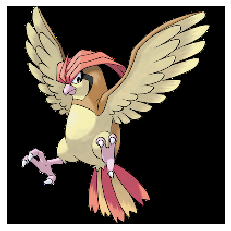

In [14]:
plt.imshow(batch[2])
plt.axis('off');
plt.show()

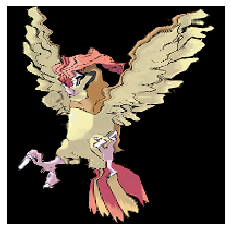

In [15]:
plt.imshow(aug_batch[2])
plt.axis('off');
plt.show()

In [16]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(train_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size, ) + image_size), tf.TensorShape((batch_size, ) + image_size))
)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(test_gen), 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size, ) + image_size), tf.TensorShape((batch_size, ) + image_size))
)


In [17]:
_instance_scale=1.0
for data in generator_augmentor(train_gen):
    _instance_scale = float(data[0].max())
    break

In [18]:
_instance_scale

1.0

In [19]:
import numpy as np
from collections.abc import Iterable

In [20]:
if isinstance(inputs_shape, Iterable):
    _outputs_shape = np.prod(inputs_shape)

In [21]:
_outputs_shape

120000

# Model's Layers definition

In [22]:
enc_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=latents_dim)]

dec_lays = [tf.keras.layers.Dense(units=latents_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=_outputs_shape),
            tf.keras.layers.Reshape(inputs_shape)]

# Model definition

In [23]:
model_name = dataset_name+'_augmented_TAE_Dense_reconst_ell'
experiments_dir='experiments'+sep_local+model_name

In [24]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [25]:
inputs_shape=image_size

In [26]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latents_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latents_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [27]:
from utils.data_and_files.file_utils import create_if_not_exist

In [28]:
_restore = os.path.join(experiments_dir, 'var_save_dir')

In [29]:
create_if_not_exist(_restore)
_restore

'experiments\\pokemon_augmented_TAE_Dense_reconst_ell\\var_save_dir'

In [30]:
#to restore trained model, set filepath=_restore

In [31]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 200, 200, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 200, 200, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 1280000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40960032  
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 120000)            3960000   
_________________________________________________________________
reshape (Reshape)            (None, 200, 200, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 3)       12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 3)       0

  WARNING  | None


xxx (200, 200, 3)
xxx (200, 200, 3)


In [32]:
#ae.compile(metrics=None)
ae.compile()

Model: "pokemon_augmented_TAE_Dense_reconst_ell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
inference (Model)            (None, 32)                40961344  
_________________________________________________________________
generative (Model)           (None, 200, 200, 3)       3962124   
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 200, 200, 3)]     0         
Total params: 44,923,468
Trainable params: 44,923,398
Non-trainable params: 70
_________________________________________________________________
None


# Callbacks

In [33]:
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [35]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [36]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

'experiments\\pokemon_augmented_TAE_Dense_reconst_ell\\csv_dir\\pokemon_augmented_TAE_Dense_reconst_ell.csv'

In [37]:
image_gen_dir = os.path.join(experiments_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [38]:
sg = SampleGeneration(latents_shape=latents_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

In [39]:
import numpy as np

# Model Training

In [40]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=10,#1000
    epochs=10,#int(1e6), 
    verbose=2,
    callbacks=[ es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=test_ds,
    validation_steps=10#1000
)

Train for 10 steps, validate for 10 steps
Epoch 1/10


AttributeError: 'autoencoder' object has no attribute 'inputs_shape'

In [ ]:
stop

In [ ]:
import numpy as np
mean_fn = lambda x: np.mean(x, axis=0)
sigma_fn = lambda x: np.cov(x, rowvar=False)

from tqdm import tqdm
def bootstrapping(data_generator, func, tolerance_threshold=1e-12):
    outputs = func(next(data_generator))
    
    for data in tqdm(data_generator):
        new_outputs = np.mean([func(data), outputs], axis=0)
        diff_outputs = np.absolute(outputs-new_outputs)
        outputs = new_outputs
        if all(diff_outputs<=tolerance_threshold):
            break
    return outputs

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input


def frechet_inception_distance(model, data_generator):
    def calculate_fid(generated_mean, generated_sigma, inception_mean, inception_sigma):
        """Numpy implementation of the Frechet Distance.
           The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
           and X_2 ~ N(mu_2, C_2) is
                    d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
           Stable version by Dougal J. Sutherland.
           Params:
            -- mu1(generated_mean) : Numpy array containing the activations of the pool_3 layer of the
                     inception net ( like returned by the function 'get_predictions')
                     for generated samples.
            -- mu2(inception_mean)  : The sample mean over activations of the pool_3 layer, precalcualted
                       on an representive data set.
            -- sigma1(generated_sigma): The covariance matrix over activations of the pool_3 layer for
                       generated samples.
            -- sigma2(inception_sigma): The covariance matrix over activations of the pool_3 layer,
                       precalcualted on an representive data set.
           Returns:
            --   : The Frechet Distance.
        """

        # calculate sum squared difference between means
        ssdiff = np.sum((generated_mean - inception_mean)**2.0)
        # calculate sqrt of product between cov
        covmean = np.sqrtm(sigma1.dot(inception_sigma))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(generated_sigma + inception_sigma - 2.0 * covmean)
        return fid
    
    # prepare the inception v3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=image_size)
    inception_predictions = lambda x: inception_model.prediction(inception_preprocess_input(x))
    def inception_predictions_generator():
        while True:
            data = next(data_generator)
            yield inception_predictions(data)

    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = model.generate_random_images()
            yield inception_predictions(data)


    generated_images_mean = bootstrapping(data_generator=model_random_images_generator, func=mean_fn)
    generated_images_sigma = bootstrapping(data_generator=model_random_images_generator, func=sigma_fn)
    inception_images_mean = bootstrapping(data_generator=inception_predictions_generator, func=mean_fn)
    inception_images_sigma = bootstrapping(data_generator=inception_predictions_generator, func=mean_fn)
    
    return calculate_fid(generated_images_mean, generated_images_sigma, inception_images_mean, inception_images_sigma)

In [ ]:
def inception_score(model):
    def calculate_is(x):
        kl = x * (np.log(x) - np.log(np.expand_dims(np.mean(x, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        return np.exp(kl)
    
    # prepare the inception v3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=image_size)
    inception_predictions = lambda x: inception_model.prediction(preprocess_input(x))

    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = model.generate_random_images()
            yield inception_predictions(data)

    is_mean  = bootstrapping(data_generator=model_random_images_generator, func=lambda x: mean_fn(calculate_is(x)))
    is_sigma = bootstrapping(data_generator=model_random_images_generator, func=sigma_fn(calculate_is(x)))
    
    return is_mean, is_sigma

In [ ]:
import tensorflow as tf
epsilon=1e-4    

tft=tf.transpose
def _i(x): return tft(x,[0,2,3,1])
def _o(x): return tft(x,[0,3,1,2])

# Load pre-trained model weights.
def get_parameters(shape, name):
    w = tf.get_variable(name, shape=shape, initializer=tf.initializers.zeros())
    return w

# Zhang weighting.
def zhang_weighting(x, fmaps, weights_name):
    w = get_parameters([1,1,fmaps,1], weights_name)
    w = tf.cast(w, x.dtype)
    return _o(tf.nn.conv2d(_i(x), w, strides=[1,1,1,1], padding='SAME', data_format='NHWC'))


In [ ]:
from tqdm import tqdm
def bootstrapping_additive(data_generator, func, stopping_func, tolerance_threshold=1e-12):
    outputs = [func(next(data_generator))]
    results = stopping_func(outputs)
    
    for data in tqdm(data_generator):
        outputs += [func(data)]
        new_results = stopping_func(outputs) 
        
        diff_results = np.absolute(results-new_results)
        results = new_results
        if all(diff_results<=tolerance_threshold):
            break
    return results


In [ ]:
# Normalize batch of vectors.
def normalize(v):
    return v / tf.sqrt(tf.reduce_sum(tf.square(v), axis=-1, keepdims=True))

# Spherical interpolation of a batch of vectors.
def slerp(a, b, t):
    a = normalize(a)
    b = normalize(b)
    d = tf.reduce_sum(a * b, axis=-1, keepdims=True)
    p = t * tf.math.acos(d)
    c = normalize(b - d * a)
    d = a * tf.math.cos(p) + c * tf.math.sin(p)
    return normalize(d)

from tensorflow.keras.applications import VGG16
def perceptual_path_length_score(model, data_generator):
    # prepare the inception v3 model
    VGG16_model = VGG16(include_top=False, pooling='avg', input_shape=model.input_shape)
    VGG16_featues_fn = lambda x: VGG16_model(x)
    

    def learned_perceptual_image_patch_similarity(images_a, images_b):
        """LPIPS metric using VGG-16 and Zhang weighting. (https://arxiv.org/abs/1801.03924)

        Takes reference images and corrupted images as an input and outputs the perceptual
        distance between the image pairs.
        """

        # Concatenate images.
        images = tf.concat([images_a, images_b], axis=0)

        # Extract features.
        vgg_features = VGG16_featues_fn(images)

        # Normalize each feature vector to unit length over channel dimension.
        normalized_features = []
        for x in vgg_features:
            n = tf.reduce_sum(x**2, axis=1, keepdims=True) ** 0.5
            normalized_features.append(x / (n + 1e-10))

        # Split and compute distances.
        diff = [tf.subtract(*tf.split(x, 2, axis=0))**2 for x in normalized_features]

        # Apply weighting from Zhang et al.
        reduced = [zhang_weighting(x, fmaps, 'perceptual_weight_%i' % i) for i, (x, fmaps) in enumerate(zip(diff, ZHANG_WEIGHTING_FMAPS))]

        # Reduce across pixels and layers.
        result = sum([tf.reduce_mean(x, axis=[2, 3]) for x in reduced])
        result = tf.reshape(result, [-1])

        return result

    def filter_distances_fn(distances):
       # Reject outliers.
        lo = np.percentile(distances, 1, interpolation='lower')
        hi = np.percentile(distances, 99, interpolation='higher')
        filtered_distances = np.extract(np.logical_and(lo <= distances, distances <= hi), distances)
        return filtered_distances
    
    def calculate_distances(images):
        images = images[0::2], images[1::2]
        return learned_perceptual_image_patch_similarity(images01, images02) * (1 / epsilon**2)
    
    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            # Generate random latents and interpolation t-values.
            ln = np.random.normal(size=[model.latents_dim])
            latents_t = np.array([ln for _ in range(model.batch_size)])
            lerp_t = np.random.uniform()
            
            # Generate latents from the data
            latents_real = model.encode(next(data_generator))

            latents_e0 = slerp(latents_real[0::2], latents_t[1::2], lerp_t)
            latents_e1 = slerp(latents_real[0::2], latents_t[1::2], lerp_t+epsilon)
            
            latents_e = np.vstack([latents_e0, latents_e1])
            
            images = model.reconstruct(latents_e)

            yield images
            # calculate_distances(images[0::2], images[1::2])
    
    def stopping_fn(distances):
        # Reject outliers.
        filter_distances = filter_distances_fn(distances)
        return np.mean(distances)
    
    ppl_mean  = bootstrapping_additive(
                                        data_generator=model_random_images_generator, func=calculate_distances, \
                                        stopping_func=stopping_fn
                                )
    
    return ppl_mean

In [ ]:
import numpy as np
def batch_pairwise_distances(U, V):
    """ Compute pairwise distances between two batches of feature vectors."""
    # Squared norms of each row in U and V.
    norm_u = np.sum(np.square(U), 1)
    norm_v = np.sum(np.square(V), 1)

    # norm_u as a row and norm_v as a column vectors.
    norm_u = np.reshape(norm_u, [-1, 1])
    norm_v = np.reshape(norm_v, [1, -1])

    # Pairwise squared Euclidean distances.
    D = np.maximum(norm_u - 2*np.matmul(U, V.T) + norm_v, 0.0)

    return D

class ManifoldEstimator():
    """Finds an estimate for the manifold of given feature vectors."""
    def __init__(self, features, row_batch_size, col_batch_size, nhood_sizes, clamp_to_percentile=None):
        """Find an estimate of the manifold of given feature vectors."""
        num_images = features.shape[0]
        self.nhood_sizes = nhood_sizes
        self.num_nhoods = len(nhood_sizes)
        self.row_batch_size = row_batch_size
        self.col_batch_size = col_batch_size
        self._ref_features = features
        self._distance_block = distance_block

        # Estimate manifold of features by calculating distances to kth nearest neighbor of each sample.
        self.D = np.zeros([num_images, self.num_nhoods], dtype=np.float16)
        distance_batch = np.zeros([row_batch_size, num_images], dtype=np.float16)
        seq = np.arange(max(self.nhood_sizes) + 1, dtype=np.int32)

        for begin1 in range(0, num_images, row_batch_size):
            end1 = min(begin1 + row_batch_size, num_images)
            row_batch = features[begin1:end1]

            for begin2 in range(0, num_images, col_batch_size):
                end2 = min(begin2 + col_batch_size, num_images)
                col_batch = features[begin2:end2]

                # Compute distances between batches.
                distance_batch[0:end1-begin1, begin2:end2] = batch_pairwise_distances(row_batch, col_batch)

            # Find the kth nearest neighbor from the current batch.
            self.D[begin1:end1, :] = np.partition(distance_batch[0:end1-begin1, :], seq, axis=1)[:, self.nhood_sizes]

        if clamp_to_percentile is not None:
            max_distances = np.percentile(self.D, clamp_to_percentile, axis=0)
            self.D[self.D > max_distances] = 0  #max_distances  # 0

    def evaluate(self, eval_features, return_realism=False, return_neighbors=False):
        """Evaluate if new feature vectors are in the estimated manifold."""
        num_eval_images = eval_features.shape[0]
        num_ref_images = self.D.shape[0]
        distance_batch = np.zeros([self.row_batch_size, num_ref_images], dtype=np.float16)
        batch_predictions = np.zeros([num_eval_images, self.num_nhoods], dtype=np.int32)

        realism_score = np.zeros([num_eval_images,], dtype=np.float32)
        nearest_indices = np.zeros([num_eval_images,], dtype=np.int32)

        for begin1 in range(0, num_eval_images, self.row_batch_size):
            end1 = min(begin1 + self.row_batch_size, num_eval_images)
            feature_batch = eval_features[begin1:end1]

            for begin2 in range(0, num_ref_images, self.col_batch_size):
                end2 = min(begin2 + self.col_batch_size, num_ref_images)
                ref_batch = self._ref_features[begin2:end2]

                distance_batch[0:end1-begin1, begin2:end2] = batch_pairwise_distances(feature_batch, ref_batch)

            # From the minibatch of new feature vectors, determine if they are in the estimated manifold.
            # If a feature vector is inside a hypersphere of some reference sample, then the new sample lies on the estimated manifold.
            # The radii of the hyperspheres are determined from distances of neighborhood size k.
            samples_in_manifold = distance_batch[0:end1-begin1, :, None] <= self.D
            batch_predictions[begin1:end1] = np.any(samples_in_manifold, axis=1).astype(np.int32)

            nearest_indices[begin1:end1] = np.argmin(distance_batch[0:end1-begin1, :], axis=1)
            realism_score[begin1:end1] = self.D[nearest_indices[begin1:end1], 0] / np.min(distance_batch[0:end1-begin1, :], axis=1)

        if return_realism and return_neighbors:
            return batch_predictions, realism_score, nearest_indices
        elif return_realism:
            return batch_predictions, realism_score
        elif return_neighbors:
            return batch_predictions, nearest_indices

        return batch_predictions



def knn_precision_recall_features(ref_features, eval_features, feature_net, nhood_sizes, row_batch_size, col_batch_size):
    """Calculates k-NN precision and recall for two sets of feature vectors."""
    state = dict()
    #num_images = ref_features.shape[0]
    num_features = feature_net.output_shape[1]
    state['ref_features'] = ref_features
    state['eval_features'] = eval_features

    # Initialize DistanceBlock and ManifoldEstimators.
    state.ref_manifold = ManifoldEstimator(state['ref_features'], row_batch_size, col_batch_size, nhood_sizes)
    state.eval_manifold = ManifoldEstimator(state['eval_features'], row_batch_size, col_batch_size, nhood_sizes)

    # Evaluate precision and recall using k-nearest neighbors.
    print('Evaluating k-NN precision and recall with %i samples...' % num_images)
    start = time.time()

    # Precision: How many points from eval_features are in ref_features manifold.
    state['precision'], state['realism_scores'], state['nearest_neighbors'] = state['ref_manifold'].evaluate(state['eval_features'], return_realism=True, return_neighbors=True)
    state['knn_precision'] = state['precision'].mean(axis=0)

    # Recall: How many points from ref_features are in eval_features manifold.
    state['recall'] = state['eval_manifold'].evaluate(state['ref_features'])
    state['knn_recall'] = state['recall'].mean(axis=0)

    elapsed_time = time.time() - start
    print('Done evaluation in: %gs' % elapsed_time)

    return state



In [ ]:
from tensorflow.keras.applications import VGG16
def precision_score(model, data_generator, nhood_size=3, row_batch_size=10000, col_batch_size=10000):
    # prepare the inception v3 model
    VGG16_model = VGG16(include_top=False, pooling='avg', input_shape=model.input_shape)
    VGG16_featues_fn = lambda x: VGG16_model(x)
        
    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = next(data_generator)
            ref_features = VGG16_featues_fn(data)
            
            # Generate random latents and interpolation t-values.
            ln = np.random.normal(size=[model.latents_dim])
            latents_t = np.array([ln for _ in range(model.batch_size)])
            lerp_t = np.random.uniform()
            
            # Generate latents from the data
            latents_real = model.encode(data)

            latents_e0 = slerp(latents_real[0::2], latents_t[1::2], lerp_t)
            latents_e1 = slerp(latents_real[0::2], latents_t[1::2], lerp_t+epsilon)
            
            latents_e = np.vstack([latents_e0, latents_e1])
            
            images = model.reconstruct(latents_e)
            
            eval_features = VGG16_featues_fn(images)

            # Calculate precision and recall.
            state = knn_precision_recall_features(ref_features=ref_features, eval_features=eval_features, feature_net=VGG16_model,
                nhood_sizes=[nhood_size], row_batch_size=row_batch_size, col_batch_size=row_batch_size)
            
            knn_precision = state['knn_precision'][0]
            knn_recall = state['knn_recall'][0]
            yield knn_precision, knn_recall
    
    knn_precision_mean = bootstrapping(data_generator=model_random_images_generator, func=mean_fn)

    return knn_precision_mean

In [ ]:
from tensorflow.keras.applications import VGG16
def recall_score(model, data_generator, nhood_size=3, row_batch_size=10000, col_batch_size=10000):
    # prepare the inception v3 model
    VGG16_model = VGG16(include_top=False, pooling='avg', input_shape=model.input_shape)
    VGG16_featues_fn = lambda x: VGG16_model(x)
        
    # prepare the ae model random_images_generator
    def model_random_images_generator():
        while True:
            data = next(data_generator)
            ref_features = VGG16_featues_fn(data)
            
            # Generate random latents and interpolation t-values.
            ln = np.random.normal(size=[model.latents_dim])
            latents_t = np.array([ln for _ in range(model.batch_size)])
            lerp_t = np.random.uniform()
            
            # Generate latents from the data
            latents_real = model.encode(data)

            latents_e0 = slerp(latents_real[0::2], latents_t[1::2], lerp_t)
            latents_e1 = slerp(latents_real[0::2], latents_t[1::2], lerp_t+epsilon)
            
            latents_e = np.vstack([latents_e0, latents_e1])
            
            images = model.reconstruct(latents_e)
            
            eval_features = VGG16_featues_fn(images)

            # Calculate precision and recall.
            state = knn_precision_recall_features(ref_features=ref_features, eval_features=eval_features, feature_net=VGG16_model,
                nhood_sizes=[nhood_size], row_batch_size=row_batch_size, col_batch_size=row_batch_size)
            
            knn_precision = state['knn_precision'][0]
            knn_recall = state['knn_recall'][0]
            yield knn_recall
    
    knn_recall_mean = bootstrapping(data_generator=model_random_images_generator, func=mean_fn)

    return knn_recall_mean